In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



# LOAD CONTACT MATRICES
contact_matrix_zero = np.load('data/hic/wildtype_100kb_zeroed.npy')

In [4]:
def optimize_clique_size(contact_matrix, max_clique_size, seed_bin, num_samples=1000):
    print(f"Starting optimize_clique_size: max_clique_size={max_clique_size}, seed_bin={seed_bin}, num_samples={num_samples}")

    # 1) Compute the full-size TTN clique once
    ttn_full = cf.find_greedy_clique(contact_matrix, max_clique_size, seed_bin)
    print(f"Computed TTN full clique of size {len(ttn_full)}")

    # 2) Sample background cliques at full size
    bg_full = []
    for _ in tqdm(range(num_samples), desc="Sampling background cliques"):
        random_bin = np.random.randint(contact_matrix.shape[0])  
        bg_full.append(
            cf.find_greedy_clique(contact_matrix, max_clique_size, random_bin)
        )
    print("Background sampling complete.")

    sizes = list(range(1, max_clique_size + 1))
    ttn_scores, p_values, fold_changes = [], [], []
    bg_dists = {}

    
    print("Processing clique sizes...")
    for size in range(sizes):
        print(f"\nSize {size}/{max_clique_size}")

        # TTN subclique and score
        ttn_sub = ttn_full[:size]
        ttn_score = core.stats.calculate_avg_interaction_strength(contact_matrix, ttn_sub)
        print(f"  TTN score: {ttn_score:.4f}")

        # Background subcliques and scores
        bg_scores = [
            core.stats.calculate_avg_interaction_strength(contact_matrix, clique[:size])
            for clique in bg_full
        ]
        bg_dists[size] = bg_scores

        # Compute statistics
        median_bg = np.median(bg_scores)
        pval = (np.sum(np.array(bg_scores) >= ttn_score) + 1) / (num_samples + 1)
        fold = ttn_score / median_bg if median_bg != 0 else float('nan')

        print(f"  Median background: {median_bg:.4f}")
        print(f"  p-value: {pval:.4f}")
        print(f"  Fold change: {fold:.4f}")

        # Store
        ttn_scores.append(ttn_score)
        p_values.append(pval)
        fold_changes.append(fold)

    print("Completed optimize_clique_size")
    return sizes, ttn_scores, p_values, fold_changes, bg_dists

In [5]:
sizes, ttn_scores, pvals, folds, bg = optimize_clique_size(
    contact_matrix=contact_matrix_zero,
    max_clique_size=20,
    seed_bin=TTN_BIN,
    num_samples=5000
)

# then you can e.g. plot fold vs size or pval vs size

Starting optimize_clique_size: max_clique_size=20, seed_bin=4275, num_samples=5000
Computed TTN full clique of size 20


Sampling background cliques: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:19<00:00, 19.26it/s]


Background sampling complete.


Processing clique sizes:  30%|██████████████████████████████████████████                                                                                                  | 6/20 [00:00<00:00, 51.77it/s]


Size 1/20
  TTN score: 0.0000
  Median background: 0.0000
  p-value: 1.0000
  Fold change: nan

Size 2/20
  TTN score: 0.0003
  Median background: 0.0010
  p-value: 0.7193
  Fold change: 0.3198

Size 3/20
  TTN score: 0.0006
  Median background: 0.0038
  p-value: 0.7902
  Fold change: 0.1720

Size 4/20
  TTN score: 0.0007
  Median background: 0.0037
  p-value: 0.8620
  Fold change: 0.1753

Size 5/20
  TTN score: 0.0102
  Median background: 0.0033
  p-value: 0.0960
  Fold change: 3.1187

Size 6/20
  TTN score: 0.0073
  Median background: 0.0029
  p-value: 0.1116
  Fold change: 2.5021

Size 7/20
  TTN score: 0.0061
  Median background: 0.0027
  p-value: 0.1316
  Fold change: 2.2303

Size 8/20
  TTN score: 0.0051
  Median background: 0.0025
  p-value: 0.1396
  Fold change: 2.0658

Size 9/20
  TTN score: 0.0043
  Median background: 0.0022
  p-value: 0.1508
  Fold change: 1.9145

Size 10/20
  TTN score: 0.0037
  Median background: 0.0021
  p-value: 0.1632
  Fold change: 1.7821

Size 11/20


Processing clique sizes:  60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 12/20 [00:00<00:00, 16.85it/s]

  Median background: 0.0019
  p-value: 0.1946
  Fold change: 1.6411

Size 12/20
  TTN score: 0.0029
  Median background: 0.0018
  p-value: 0.1962
  Fold change: 1.5870

Size 13/20
  TTN score: 0.0026
  Median background: 0.0019
  p-value: 0.1832
  Fold change: 1.3896

Size 14/20
  TTN score: 0.0024
  Median background: 0.0017
  p-value: 0.1912
  Fold change: 1.3617

Size 15/20
  TTN score: 0.0021


Processing clique sizes:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 15/20 [00:01<00:00, 10.63it/s]

  Median background: 0.0017
  p-value: 0.2070
  Fold change: 1.2808

Size 16/20
  TTN score: 0.0020
  Median background: 0.0016
  p-value: 0.2100
  Fold change: 1.2354

Size 17/20
  TTN score: 0.0018


Processing clique sizes:  85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 17/20 [00:01<00:00,  7.90it/s]

  Median background: 0.0015
  p-value: 0.2194
  Fold change: 1.1972

Size 18/20
  TTN score: 0.0017
  Median background: 0.0014
  p-value: 0.2350
  Fold change: 1.1786

Size 19/20
  TTN score: 0.0015


Processing clique sizes:  95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 19/20 [00:02<00:00,  6.03it/s]

  Median background: 0.0013
  p-value: 0.2669
  Fold change: 1.1484

Size 20/20
  TTN score: 0.0014


Processing clique sizes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.74it/s]

  Median background: 0.0013
  p-value: 0.2889
  Fold change: 1.1282
Completed optimize_clique_size


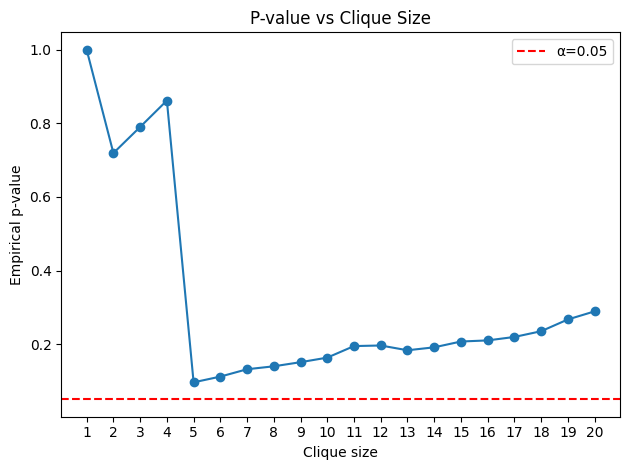

Optimal clique size = 5, p-value = 0.0960


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Plot p-value vs size
plt.figure()
plt.plot(sizes, pvals, marker='o', linestyle='-')
plt.axhline(0.05, color='red', linestyle='--', label='α=0.05')
plt.xlabel('Clique size')
plt.ylabel('Empirical p-value')
plt.title('P-value vs Clique Size')
plt.xticks(sizes)
plt.legend()
plt.tight_layout()
plt.show()

# 2) Choose the size with minimum p-value
opt_idx = int(np.argmin(pvals))
opt_size = sizes[opt_idx]
opt_pval = pvals[opt_idx]
print(f'Optimal clique size = {opt_size}, p-value = {opt_pval:.4f}')

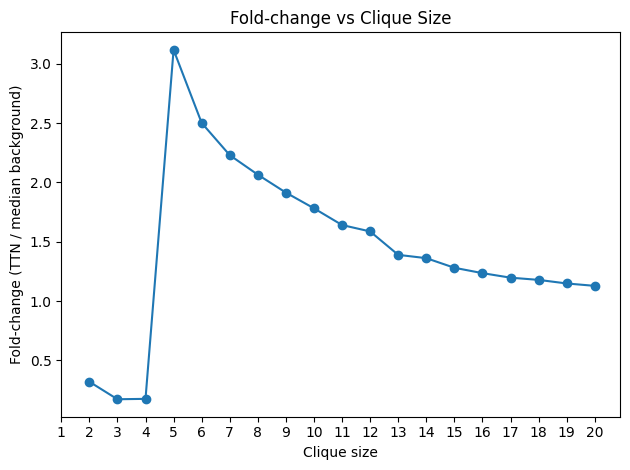

In [8]:
plt.figure()
plt.plot(sizes, folds, marker='o', linestyle='-')
plt.xlabel('Clique size')
plt.ylabel('Fold-change (TTN / median background)')
plt.title('Fold-change vs Clique Size')
plt.xticks(sizes)
plt.tight_layout()
plt.show()

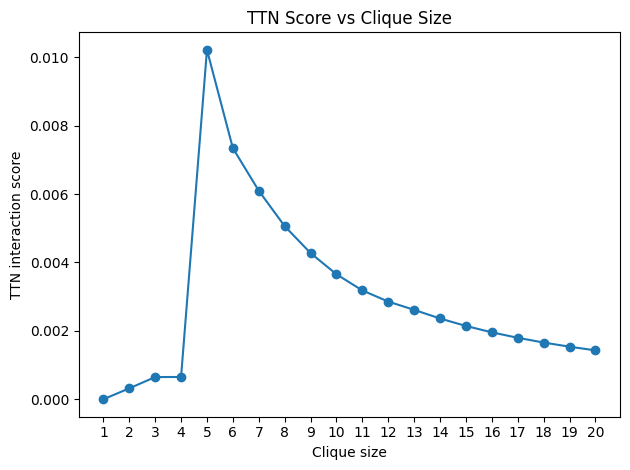

In [9]:
plt.figure()
plt.plot(sizes, ttn_scores, marker='o', linestyle='-')
plt.xlabel('Clique size')
plt.ylabel('TTN interaction score')
plt.title('TTN Score vs Clique Size')
plt.xticks(sizes)
plt.tight_layout()
plt.show()

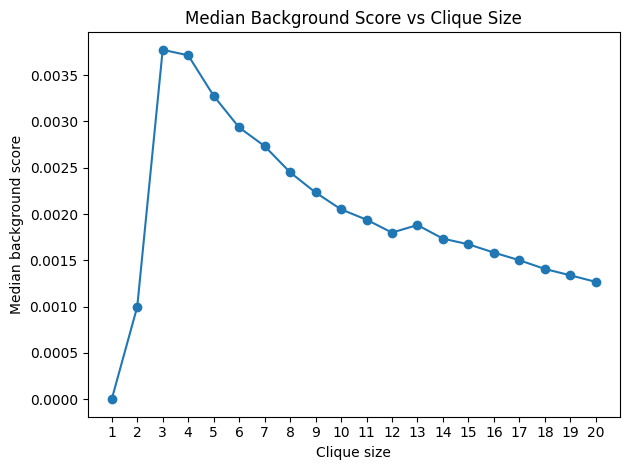

In [11]:
medians = [np.median(bg[size]) for size in sizes]
plt.figure()
plt.plot(sizes, medians, marker='o', linestyle='-')
plt.xlabel('Clique size')
plt.ylabel('Median background score')
plt.title('Median Background Score vs Clique Size')
plt.xticks(sizes)
plt.tight_layout()
plt.show()

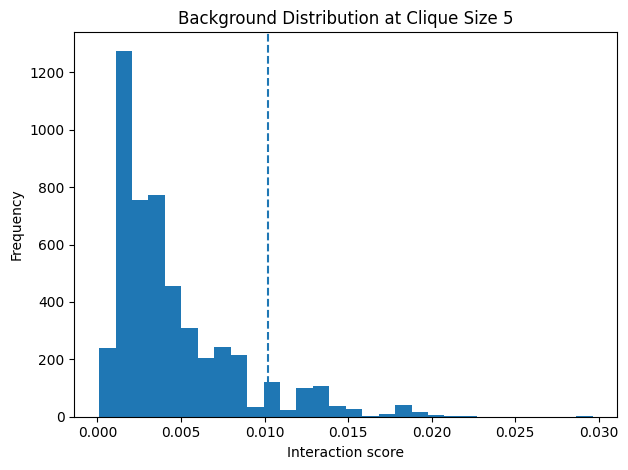

In [13]:
opt_p_idx = int(np.argmin(pvals))
opt_size = sizes[opt_p_idx]
bg_best = bg[opt_size]

plt.figure()
plt.hist(bg_best, bins=30)
plt.axvline(ttn_scores[opt_p_idx], linestyle='--')
plt.xlabel('Interaction score')
plt.ylabel('Frequency')
plt.title(f'Background Distribution at Clique Size {opt_size}')
plt.tight_layout()
plt.show()

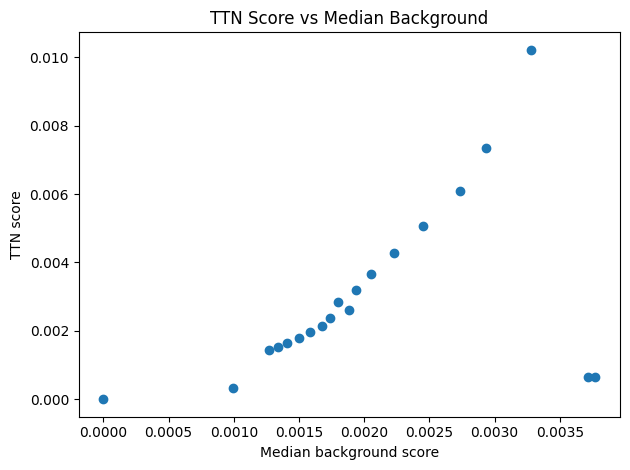

In [14]:
plt.figure()
plt.scatter(medians, ttn_scores)
plt.xlabel('Median background score')
plt.ylabel('TTN score')
plt.title('TTN Score vs Median Background')
plt.tight_layout()
plt.show()

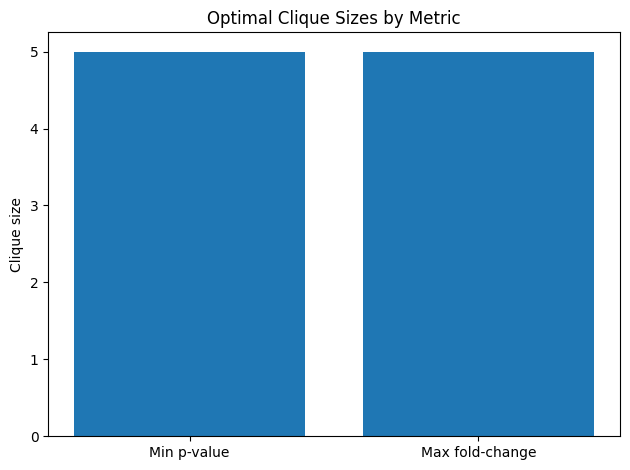

In [16]:
opt_fold_idx = int(np.nanargmax(folds))
labels = ['Min p-value', 'Max fold-change']
values = [sizes[opt_p_idx], sizes[opt_fold_idx]]

plt.figure()
plt.bar(labels, values)
plt.ylabel('Clique size')
plt.title('Optimal Clique Sizes by Metric')
plt.tight_layout()
plt.show()